# <a id='toc1_'></a>[深層学習ノートブック-15 Learning Rate Finder & Scheduler](#toc0_)
学習率は深層学習において最も重要なハイパーパラメータの一つである。  
Learning Rate Finderという下記のような手法を使えば、学習率の初期値の目安を探すことが出来る。  
1. 非常に小さい値(例:1e-8)を学習率に設定する
2. 各"ミニバッチ"の学習毎に徐々に(log scaleで)学習率を大きくする
3. ある程度大きくなると、損失が急激に上昇し始める(適切な学習率の上限)
4. 損失と学習率のグラフを描き、損失が下がり始める範囲の学習率を使用する(ここが良い学習率の範囲とされる)

参考：  
* [Udemy講座：「①米国AI開発者がやさしく教える深層学習超入門第一弾【Pythonで実践】」](https://www.udemy.com/course/deeplearning1/learn/lecture/40143418)

## ■ Learning rate finderをスクラッチで実装する
PytorchにはLearning rate finderは実装されていない※ので、自分で実装する必要あり。また、この方が応用も効く。

※サードパーティーライブラリのPytorch Lightningnにはある模様サードパーティーライブラリのPytorch Lightningnにはある模様

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch import optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [133]:
class MLP_1(nn.Module):
    def __init__(self, num_in, num_hidden, num_out):
        # 親クラスのinitを呼び出す。
        super().__init__()
        # nn.Flattenにより[b, c, h, w] -> [b, c x h x w]（ミニバッチサイズ, 画像の特徴量数の積）に変換
        self.flatten = nn.Flatten()
        self.linear_1 = nn.Linear(num_in, num_hidden)
        self.linear_2 = nn.Linear(num_hidden, num_out)

    # nn.Moduleにもforwardメソッドがあり、ここでオーバーライドしている。
    def forward(self, x):
        # 最初の全結合層の計算に渡す際にnn.Flattenを実行しておく必要あり。
        z = self.linear_2( F.relu( self.linear_1(self.flatten(x))) )
        return z
    

class MyDataset(Dataset):
    def __init__(self, X, y, transform=None) -> None:
        self.X = X
        self.y = y
        self.transform = transform
    
    def __len__(self): #lenを適用したときの挙動を定義
        return len(self.X)
    
    def __getitem__(self, idx): #indexingしたときの挙動
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)
        
        return X, y

In [184]:
# 学習率の目安を探すための関数
def learning_rate_finder(model, train_loader, loss_func, lr_increase_ratio=1.1):

    # 学習率の初期値は小さく定義。最大値を超えたら探索をやめる
    lr = 1e-8
    max_lr = 10
    # 学習率と損失記録用リスト
    lr_history = []
    loss_history = []

    # Optimizer定義。学習率は後で変更できる。
    optimizer = optim.SGD(model.parameters(), lr=lr)

    for idx_batches, data in enumerate(train_loader):
        X_train, y_train = data

        # 順伝播
        y_pred = model(X_train)
        loss = loss_func(y_pred, y_train)

        # 逆伝搬
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # グラフ描画用情報記録。学習率は見やすさのためにlog scaleにしておく。
        loss_history.append(loss.item())
        lr_history.append(lr)
        print(f"ミニバッチidx: {idx_batches}, 学習率: {lr}, 損失: {loss.item()}")
        # print(f'Optimizer: {optimizer.param_groups[0]["lr"]}')

        # optimizerの学習率更新。lrの更新は表示用
        lr *= lr_increase_ratio
        optimizer.param_groups[0]["lr"] = lr

        if lr > max_lr:
            break

    return lr_history, loss_history   


In [190]:
# バッチサイズを定義。今回は１ミニバッチ＝３２データとする
batch_size = 8

# データ読み込み。8x8のMNISTデータセットをカスタムデータセットとして読み込む。（練習のため）
dataset = datasets.load_digits()
X = dataset['images'] # 0~16の値をもつ
X = ( X * (255. / 16.) ).astype(np.uint8)
y = dataset['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
transform = transforms.Compose([
    transforms.ToTensor(), # 0~255 -> 0~1
    transforms.Normalize((0.5,), (0.5)) # 0~1 -> -1~1
])

# Datasetとして読み込み
train_dataset = MyDataset(X_train, y_train, transform=transform)
val_dataset = MyDataset(X_val, y_val, transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)

# モデルのコンストラクタに渡す引数を定義。
num_in = 64
num_hidden = 30
num_out = 10

# モデル定義（２層のMLP）
MLP_model = MLP_1(num_in=num_in, num_hidden=num_hidden, num_out=num_out)

# requires_grad_をTrueに設定。最後に_がつくのは設定するという意味。
MLP_model.requires_grad_(True)

# torch.optimを使ってOptimizerを定義
# optimizer = optim.SGD(MLP_model.parameters(), lr=0.03)

MLP_1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=64, out_features=30, bias=True)
  (linear_2): Linear(in_features=30, out_features=10, bias=True)
)

In [191]:
lr_log, loss_log = learning_rate_finder(MLP_model, train_loader, F.cross_entropy, 1.11)

ミニバッチidx: 0, 学習率: 1e-08, 損失: 2.218879222869873
ミニバッチidx: 1, 学習率: 1.1100000000000002e-08, 損失: 2.3103322982788086
ミニバッチidx: 2, 学習率: 1.2321000000000003e-08, 損失: 2.3134565353393555
ミニバッチidx: 3, 学習率: 1.3676310000000004e-08, 損失: 2.233304977416992
ミニバッチidx: 4, 学習率: 1.5180704100000005e-08, 損失: 2.263347625732422
ミニバッチidx: 5, 学習率: 1.6850581551000006e-08, 損失: 2.3670766353607178
ミニバッチidx: 6, 学習率: 1.870414552161001e-08, 損失: 2.207068920135498
ミニバッチidx: 7, 学習率: 2.0761601528987113e-08, 損失: 2.2834975719451904
ミニバッチidx: 8, 学習率: 2.3045377697175696e-08, 損失: 2.3531103134155273
ミニバッチidx: 9, 学習率: 2.5580369243865024e-08, 損失: 2.2005245685577393
ミニバッチidx: 10, 学習率: 2.839420986069018e-08, 損失: 2.2378485202789307
ミニバッチidx: 11, 学習率: 3.15175729453661e-08, 損失: 2.192047119140625
ミニバッチidx: 12, 学習率: 3.498450596935637e-08, 損失: 2.1455392837524414
ミニバッチidx: 13, 学習率: 3.883280162598558e-08, 損失: 2.3866426944732666
ミニバッチidx: 14, 学習率: 4.3104409804844e-08, 損失: 2.231158494949341
ミニバッチidx: 15, 学習率: 4.7845894883376844e-08, 損失: 2.323

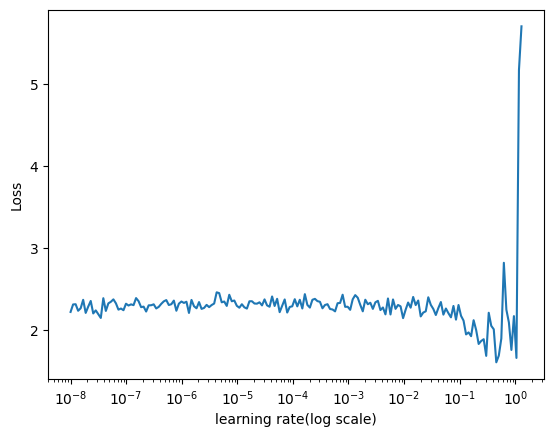

In [193]:
sns.lineplot(x=lr_log, y=loss_log)
plt.xlabel('learning rate(log scale)')
plt.ylabel('Loss')

# 学習率はlog scaleで描画
plt.xscale('log')


上記のように学習率が大きくなり過ぎると損失が発散するので、  
損失が下がり始める10^-1近傍(実スケールで0.25ぐらい)の学習率を採用するとよいということが分かる。  

(1e-07, 2.0)

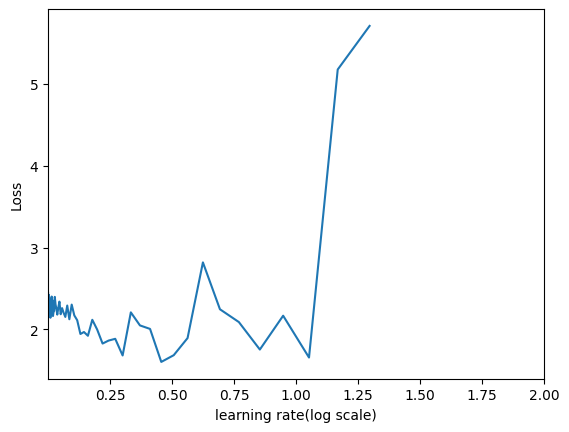

In [208]:
sns.lineplot(x=lr_log, y=loss_log)
plt.xlabel('learning rate(log scale)')
plt.ylabel('Loss')

# 学習率はlog scaleで描画
# plt.xscale('log')
plt.xlim((1e-7, 2))
